# Application of design best practices to COVID dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/COVID_analysis/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [241]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [242]:
%load_ext rpy2.ipython

In [243]:
%%R
library(tidyverse)
library(patchwork)

## Prepare dataset

Anndata objects filtered (subsampling to 500 cells per sample) and split by condition are prepared running `submit_split_PBMC_dataset.sh` and stored in `/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/tmp/`

In [25]:
data_dir = '/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/'
query_batch = '10_1038_s41591_021_01329_2'

In [5]:
normal_sample_obs = pd.read_csv(data_dir + 'PBMC_sample_metadata.normal.csv')
covid_sample_obs = pd.read_csv(data_dir + 'PBMC_sample_metadata.COVID.csv')

In [6]:
step_adata = sc.read_h5ad(data_dir + f'{query_batch}.h5ad', backed='r')

In [7]:
atlas_batch = normal_sample_obs[normal_sample_obs.dataset_id != query_batch].dataset_id.unique()

In [8]:
data_dir = '/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/'
tmp_dir = '/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/tmp/'

h5ad_files_atlas = [f'{x}.normal.subsample500cells.h5ad' for x in atlas_batch]
h5ad_files_covid = f'{query_batch}.COVID.subsample500cells.h5ad' 
h5ad_files_ctrl = f'{query_batch}.normal.subsample500cells.h5ad' 

assert os.path.exists(tmp_dir + h5ad_files_covid)
assert os.path.exists(tmp_dir + h5ad_files_ctrl)
assert all([os.path.exists(tmp_dir + x) for x in h5ad_files_atlas])

In [9]:
# check X stores raw counts 
def _check_counts_in_X(adata):
    return(all(np.random.choice(adata.X.data, 100) % 1 == 0))

def _clean_adata(a):
    ## Make obs_names unique
    a.obs_names = a.obs['dataset_id'].astype('str') + '-' + a.obs_names.astype("str")
    assert _check_counts_in_X(a)

    sc.pp.calculate_qc_metrics(a, inplace=True)
    sc.pp.filter_cells(a, min_counts=1000)

    ## Filter inside training functions instead
    ## to avoid missing genes when mapping query
    # ## Filter genes not expressed anywhere
    # sc.pp.filter_genes(a, min_cells=1)
    return(a)

### Prep atlas data

In [10]:
adata_atlas_ls = [sc.read_h5ad(tmp_dir + f) for f in h5ad_files_atlas]
for a in adata_atlas_ls:
    _clean_adata(a)

## Concatenate
adata_atlas = anndata.concat(adata_atlas_ls)

## Make var with gene names
adata_atlas.var['gene_id'] = adata_atlas.var_names.values
adata_atlas.var['gene_name'] = [a for a in adata_atlas_ls if 'feature_name' in a.var.columns][0].var['feature_name']

## Exclude 3 donors with Smart-seq2 data
adata_atlas = adata_atlas[adata_atlas.obs['assay'] != 'Smart-seq2'].copy()

## Fix dataset naming
adata_atlas.obs['dataset_id'] = [x[0] for x in adata_atlas.obs['dataset_id'].str.split("_innate")]
adata_atlas.obs['dataset_id'] = [x[0] for x in adata_atlas.obs['dataset_id'].str.split("_adaptive")]

### Prep COVID data

In [11]:
adata_covid = sc.read_h5ad(tmp_dir + h5ad_files_covid)
_clean_adata(adata_covid)

AnnData object with n_obs × n_vars = 48083 × 24727
    obs: 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'feature_biotype', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Prep control data

In [12]:
adata_ctrl = sc.read_h5ad(tmp_dir + h5ad_files_ctrl)
_clean_adata(adata_ctrl)

AnnData object with n_obs × n_vars = 14426 × 24727
    obs: 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'feature_biotype', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [13]:
## Save datasets
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [14]:
adata_atlas.obs['donor_id'] = adata_atlas.obs['donor_id'].astype("str").astype("category")
adata_covid.obs['donor_id'] = adata_covid.obs['donor_id'].astype("str").astype("category")
adata_ctrl.obs['donor_id'] = adata_ctrl.obs['donor_id'].astype("str").astype("category")

In [15]:
adata_atlas.var['gene_id'] = adata_atlas.var['gene_id'].astype("category")

In [16]:
adata_atlas.write_h5ad(outdir + 'PBMC_COVID.subsample500cells.atlas.h5ad')
adata_covid.write_h5ad(outdir + 'PBMC_COVID.subsample500cells.covid.h5ad')
adata_ctrl.write_h5ad(outdir + 'PBMC_COVID.subsample500cells.ctrl.h5ad')

## Train models

Running on farm

In [ ]:
conda activate scvi-env
cd /nfs/team205/ed6/bin/diff2atlas/scripts

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/

## Train reference models
for d in 'A' 'C' 'AC' 'PA' 'PC' 'PAC'; do     
    echo "python COVID_train_references.py ${d} --datadir ${outdir}" | \
    bsub -G teichlab -o logfile-scvi-%J.out -e logfile-scvi-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
done

## Map query datasets

In [ ]:
conda activate scvi-env
cd /nfs/team205/ed6/bin/diff2atlas/scripts

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/

for q in 'P' 'PC'; do
    echo "python COVID_map_query.py model_reference_A ${q} --datadir ${outdir}" | \
    bsub -G teichlab -o logfile-scarches-%J.out -e logfile-scarches-%J.err -q gpu-normal -M25000 -R "select[mem>25000] rusage[mem=25000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
done

echo "python COVID_map_query.py model_reference_AC P --datadir ${outdir}" | \
    bsub -G teichlab -o logfile-scarches-%J.out -e logfile-scarches-%J.err -q gpu-normal -M25000 -R "select[mem>25000] rusage[mem=25000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"


echo "python COVID_map_query.py model_reference_C P --datadir ${outdir}" | \
    bsub -G teichlab -o logfile-scarches-%J.out -e logfile-scarches-%J.err -q gpu-normal -M25000 -R "select[mem>25000] rusage[mem=25000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"

## Read outputs

In [4]:
import scvi
import shutil

data_dir = outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
adata_atlas = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.atlas.h5ad')
adata_covid = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.covid.h5ad')
adata_ctrl = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.ctrl.h5ad')
adata_dict = {'A': adata_atlas, 'P': adata_covid, 'C': adata_ctrl}


Global seed set to 0


In [7]:
def _read_design(model_query_dir, n_neighbors=100):
    ref_string = model_query_dir.split('ref')[-1]
    query_string = model_query_dir.split('_ref')[0].split('_')[-1]
    model_reference_dir = f'model_reference_{ref_string}'

    # Make merged anndata object
    print("Merging anndatas...\n")
    adata_design = anndata.concat([adata_dict[d] for d in ref_string] + [adata_dict[d] for d in query_string],
        label='dataset_group',
        keys = [d for d in ref_string] + [d for d in query_string]
        )

    print("Loading trained models...\n")
    try:
        vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
    except:
        scvi.model.SCVI.convert_legacy_save(outdir + model_reference_dir, outdir + model_reference_dir + f'_scvi{scvi.__version__}', overwrite=True)
        shutil.copyfile(outdir + model_reference_dir + '/adata.h5ad', outdir + model_reference_dir + f'_scvi{scvi.__version__}/adata.h5ad')
        vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
    try:
        vae_query = scvi.model.SCVI.load( outdir + model_query_dir + f'_scvi{scvi.__version__}')
    except:
        scvi.model.SCVI.convert_legacy_save(outdir + model_query_dir, outdir + model_query_dir + f'_scvi{scvi.__version__}', overwrite=True)
        shutil.copyfile(outdir + model_query_dir + '/adata.h5ad', outdir + model_query_dir + f'_scvi{scvi.__version__}/adata.h5ad')
        vae_query = scvi.model.SCVI.load( outdir + model_query_dir + f'_scvi{scvi.__version__}')

    model_obs_names = vae_reference.adata.obs_names.tolist() + vae_query.adata.obs_names.tolist()
    if all(model_obs_names == adata_design.obs_names):
        adata_design.obsm['X_scVI'] = np.vstack([
            vae_reference.get_latent_representation(),
            vae_query.get_latent_representation(),
            ])
    else:
        raise ValueError("Cell names don't match order in model")

    ## Remove atlas, if present
    adata_design = adata_design[adata_design.obs['dataset_group'] != 'A'].copy()

    ## Compute KNN graph
    print("Computing KNN graph...\n")
    sc.pp.neighbors(adata_design, use_rep='X_scVI', n_neighbors=n_neighbors)

    ## Run UMAP
    print("Running UMAP...\n")
    sc.tl.umap(adata_design)

    ## Save 
    file_name = f"PBMC_COVID.subsample500cells.design.{model_query_dir.split('model_')[-1]}.h5ad"
    print(f"Saving to {file_name}...\n")
    adata_design.write_h5ad(outdir + file_name)

def _read_design_scvi(model_reference_dir, n_neighbors=100):
    ref_string = model_reference_dir.split('_')[-1]
    model_reference_dir = f'model_reference_{ref_string}'

    # Make merged anndata object
    print("Merging anndatas...\n")
    adata_design = anndata.concat([adata_dict[d] for d in ref_string],
        label='dataset_group',
        keys = [d for d in ref_string]
        )

    print("Loading trained models...\n")
    try:
        vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
    except:
        scvi.model.SCVI.convert_legacy_save(outdir + model_reference_dir, outdir + model_reference_dir + f'_scvi{scvi.__version__}', overwrite=True)
        shutil.copyfile(outdir + model_reference_dir + '/adata.h5ad', outdir + model_reference_dir + f'_scvi{scvi.__version__}/adata.h5ad')
        vae_reference = scvi.model.SCVI.load(outdir + model_reference_dir + f'_scvi{scvi.__version__}')
    
    model_obs_names = vae_reference.adata.obs_names.tolist() 
    if all(model_obs_names == adata_design.obs_names):
        adata_design.obsm['X_scVI'] = vae_reference.get_latent_representation()
    else:
        raise ValueError("Cell names don't match order in model")

    ## Remove atlas, if present
    adata_design = adata_design[adata_design.obs['dataset_group'] != 'A'].copy()

    ## Compute KNN graph
    print("Computing KNN graph...\n")
    sc.pp.neighbors(adata_design, use_rep='X_scVI', n_neighbors=n_neighbors)

    ## Run UMAP
    print("Running UMAP...\n")
    sc.tl.umap(adata_design)

    ## Save 
    file_name = f"PBMC_COVID.subsample500cells.design.{model_reference_dir.split('model_reference')[-1]}.h5ad"
    print(f"Saving to {file_name}...\n")
    adata_design.write_h5ad(outdir + file_name)


In [8]:
for mq in [x for x in os.listdir(outdir) if x.startswith('model_query_') and 'scvi' not in x]:
    _read_design(mq)

for mq in ['model_reference_PC', 'model_reference_PAC']:
    _read_design_scvi(mq)


Merging anndatas...

Loading trained models...

INFO     File /lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/model_reference_A_scvi0.16.2/
         model.pt already downloaded                                                         
INFO     No backup URL provided for missing file /lustre/scratch117/cellgen/team205/ed6/PBMC_
         COVID/model_query_PC_refA_scvi0.16.2/model.pt                                       
INFO     File /lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/model_query_PC_refA_scvi0.16.
         2/model.pt already downloaded                                                       
Computing KNN graph...

Running UMAP...

Saving to {file_name}...

Merging anndatas...

Loading trained models...

INFO     No backup URL provided for missing file /lustre/scratch117/cellgen/team205/ed6/PBMC_
         COVID/model_reference_C_scvi0.16.2/model.pt                                         
INFO     File /lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/model_reference_C_scv

## Run Milo analysis

In [345]:
def run_milo(adata_design, query_group, reference_group,
             sample_col= 'sample_id',
             annotation_col= 'cell_type',
             design = '~ is_query'
             ):
            milopy.core.make_nhoods(adata_design, prop=0.1)
            milopy.core.count_nhoods(adata_design, sample_col=sample_col)
            milopy.utils.annotate_nhoods(
                adata_design[adata_design.obs['dataset_group'] == reference_group], annotation_col)
            adata_design.obs['is_query'] = adata_design.obs['dataset_group'] == query_group
            milopy.core.DA_nhoods(adata_design, design=design)

In [ ]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
## Load dataset specific obs
query_batch = '/nfs/team205/ed6/data/PBMC_CZI_integration_filtered/10_1038_s41591_021_01329_2.h5ad'
stephenson_obs = sc.read_h5ad(query_batch, backed='r').obs.copy()

### On PAC design

In [113]:
adata = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.h5ad')
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata.obs_names]]
new_obs.index = adata.obs_names
adata.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata.obs.columns)], adata.obs], 1)
run_milo(adata, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')

## Add interferon signature ##
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

## Add gene names
adata.var = adata_atlas.var.loc[adata.var_names]
adata.var_names = adata.var['gene_name'].values

## Copied from https://www.nature.com/articles/s41586-021-04345-x
ifn_signature_genes = [
    'BST2', 'CMPK2', 'EIF2AK2', 'EPSTI1', 'HERC5', 'IFI35', 'IFI44L', 'IFI6', 
    'IFIT3', 'ISG15', 'LY6E', 'MX1', 'MX2', 'OAS1', 'OAS2', 'PARP9', 'PLSCR1', 
    'SAMD9', 'SAMD9L', 'SP110', 'STAT1', 'TRIM22', 'UBE2L6', 'XAF1', 'IRF7'
    ]

sc.tl.score_genes(adata, ifn_signature_genes, score_name='IFN_signature')
milopy.utils.annotate_nhoods_continuous(adata, "IFN_signature")
milopy.utils.annotate_nhoods(adata, 'author_cell_type')
# milopy.utils.write_milo_adata(adata, data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.h5ad')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


### Compare to alternative designs

In [ ]:
## PC
adata_c = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_P_refC.h5ad')
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_c.obs_names]]
new_obs.index = adata_c.obs_names
adata_c.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_c.obs.columns)], adata_c.obs], 1)

run_milo(adata_c, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type')
adata_c.obs['IFN_signature'] = adata.obs.loc[adata_c.obs_names, 'IFN_signature']
milopy.utils.annotate_nhoods_continuous(adata_c, "IFN_signature")

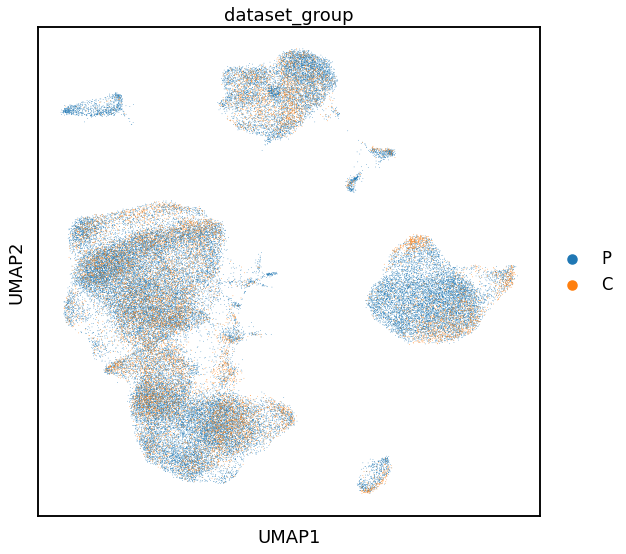

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


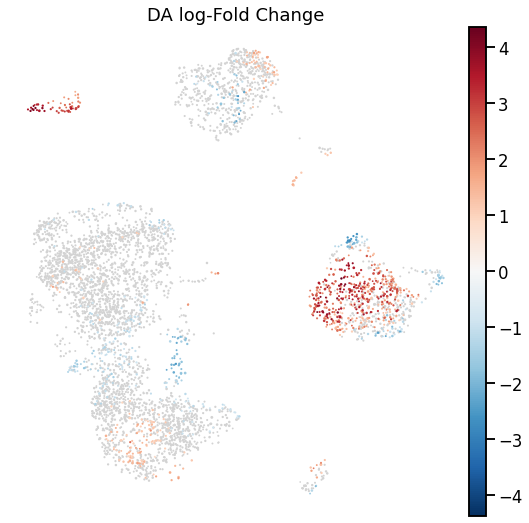

In [117]:
milopy.utils.build_nhood_graph(adata)
with rc_context({'figure.figsize':[9,9]}):
    sc.pl.umap(adata, color='dataset_group')
    milopy.plot.plot_nhood_graph(adata, min_size=0.1)

In [ ]:
adata_c = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_P_refC.h5ad')
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_c.obs_names]]
new_obs.index = adata_c.obs_names
adata_c.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_c.obs.columns)], adata_c.obs], 1)

run_milo(adata_c, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
milopy.utils.annotate_nhoods(adata_c, 'author_cell_type')
adata_c.obs['IFN_signature'] = adata.obs.loc[adata_c.obs_names, 'IFN_signature']
milopy.utils.annotate_nhoods_continuous(adata_c, "IFN_signature")

In [286]:
# ## Take out labels to plot (high perc of IFN activated)
pl_cell_types = nhood_adata.obs.loc[nhood_adata.obs['logFC'] > 1, 'nhood_annotation'].value_counts()[0:10].index
pl_cell_types = pl_cell_types[pl_cell_types != 'nan']

df1 = nhood_adata.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df1['design'] = 'PAC'
df2 = nhood_adata_c.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df2['design'] = 'PC'
pl_df = pd.concat([df1,df2])
# pl_cell_types_c = nhood_adata_c.obs.loc[nhood_adata_c.obs['nhood_IFN_signature'] > 0.1, 'nhood_annotation'].astype('str').unique()


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [287]:
%%R -i pl_df
head(pl_df)

  nhood_IFN_signature      logFC  SpatialFDR nhood_annotation design
1         -0.00220008 -0.2194488 0.773792012          NK_16hi    PAC
2         -0.06581493 -0.5853851 0.271597767        CD8.Naive    PAC
3         -0.07545920 -0.2437837 0.751638382          B_naive    PAC
4         -0.06753626  0.2168581 0.777359813           CD4.CM    PAC
5         -0.14077664 -0.2466057 0.766543201           CD4.CM    PAC
6         -0.02367600 -1.4926319 0.005747825          CD4.Tfh    PAC


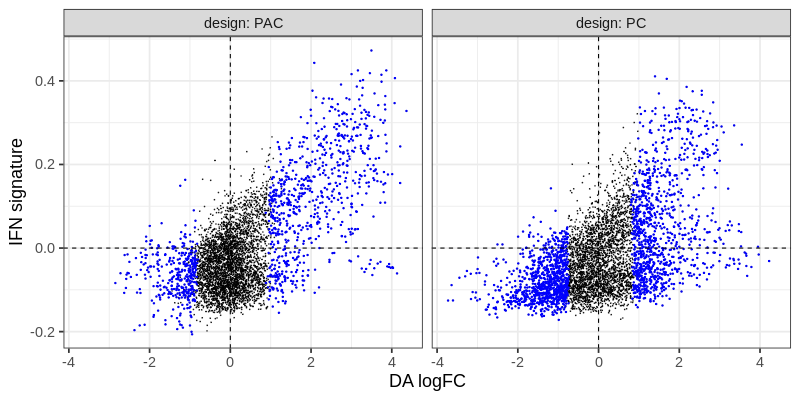

In [277]:
%%R -w 800 -h 400
pl_df %>%
group_by(nhood_annotation, design) %>%
mutate(frac_activated = sum(nhood_IFN_signature > 0.1)/n())  %>%
ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
geom_point(size=0.2, alpha=0.7) +
geom_point(data = . %>% filter(SpatialFDR < 0.1), color='blue', size=0.5, alpha=0.9) +
theme_bw(base_size=18) +
facet_grid(~design, labeller=label_both) +
scale_color_brewer(palette='Accent') +
theme(legend.position='top') +
geom_vline(xintercept=0, linetype='dashed', color='black') +
geom_hline(yintercept=0, linetype='dashed', color='black') +
xlab("DA logFC") + ylab("IFN signature")

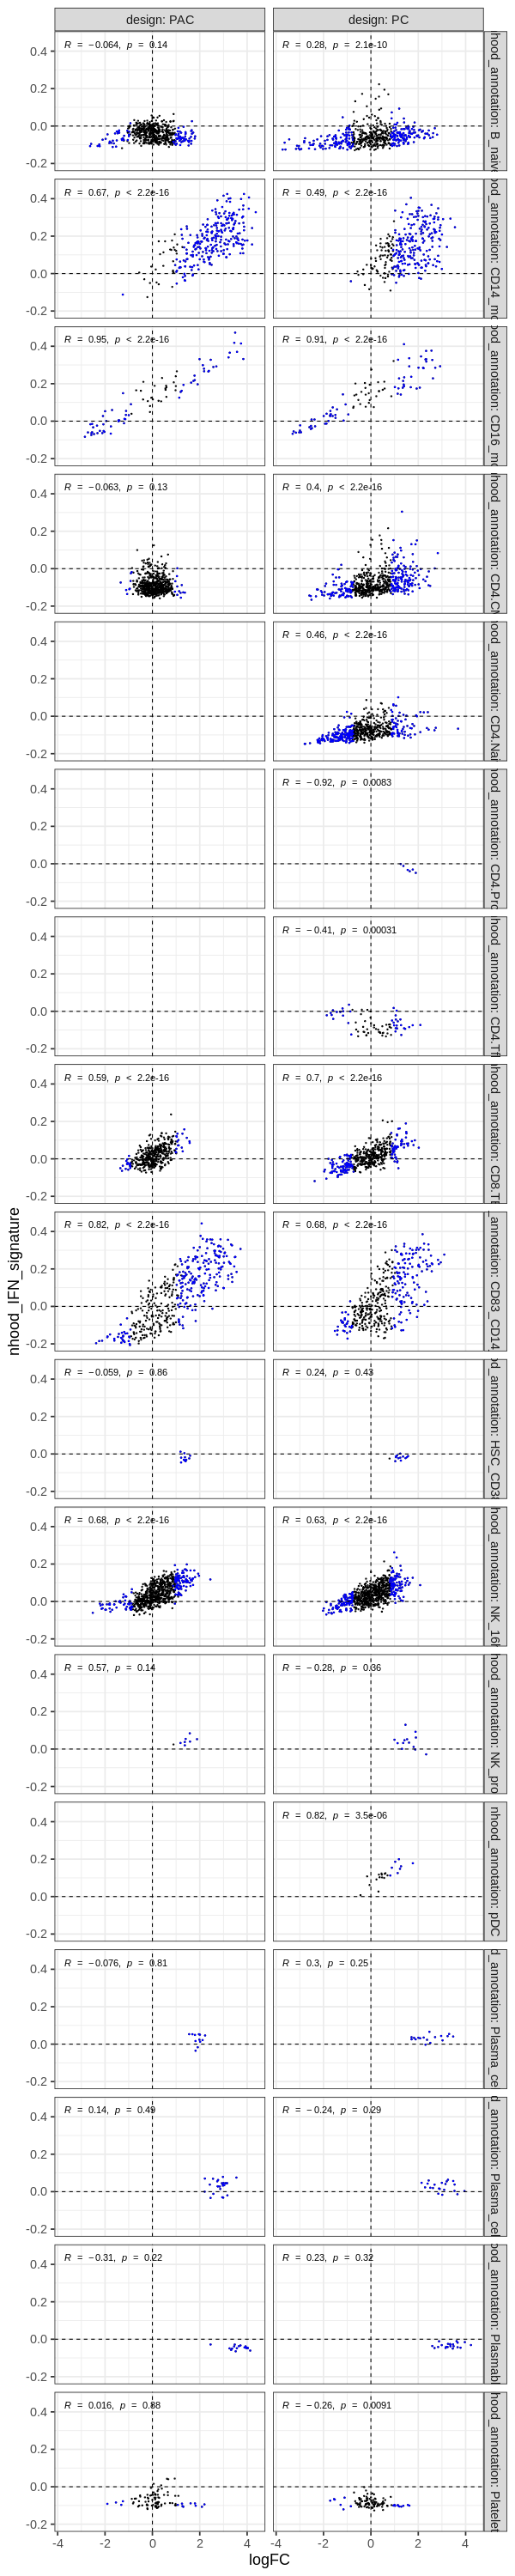

In [288]:
%%R -w 600 -h 3000
pl_df %>%
group_by(nhood_annotation, design) %>%
mutate(n_DA = sum(logFC > 1))  %>%
ungroup() %>%
filter(n_DA > 5) %>%
ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
geom_point(size=0.5, alpha=0.9) +
geom_point(data = . %>% filter(SpatialFDR < 0.1), color='blue', size=0.5, alpha=0.9) +
theme_bw(base_size=18) +
facet_grid(nhood_annotation~design, labeller=label_both) +
scale_color_brewer(palette='Accent') +
theme(legend.position='top') +
ggpubr::stat_cor() +
geom_vline(xintercept=0, linetype='dashed', color='black') +
geom_hline(yintercept=0, linetype='dashed', color='black')

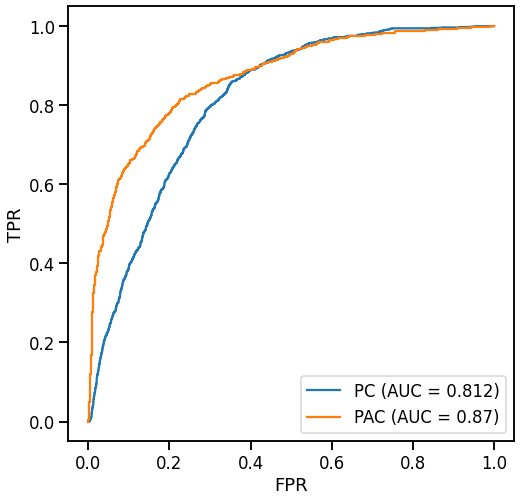

In [280]:
# scipy.stats.pearsonr(nhood_adata_c.obs['logFC'], nhood_adata_c.obs['nhood_IFN_signature'])
# scipy.stats.pearsonr(nhood_adata.obs['logFC'], nhood_adata.obs['nhood_IFN_signature'])
from sklearn.metrics import roc_curve,auc

min_sign = 0.05
nhood_adata.obs['is_IFN_activated'] = nhood_adata.obs['nhood_IFN_signature'] > min_sign
nhood_adata_c.obs['is_IFN_activated'] = nhood_adata_c.obs['nhood_IFN_signature'] > min_sign
fpr, tpr, _ = roc_curve(nhood_adata_c.obs['is_IFN_activated'], nhood_adata_c.obs['logFC'])
AUC = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'PC (AUC = {np.round(AUC, 3)})');
fpr, tpr, _ = roc_curve(nhood_adata.obs['is_IFN_activated'], nhood_adata.obs['logFC'])
AUC = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'PAC (AUC = {np.round(AUC, 3)})');
plt.legend();
plt.xlabel("FPR");
plt.ylabel("TPR");


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/plot.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_df['is_signif'] = anno_df['SpatialFDR'] < alpha


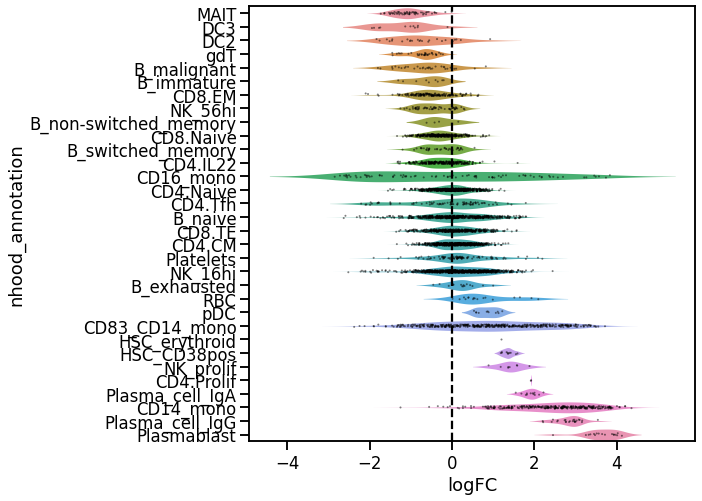

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/plot.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_df['is_signif'] = anno_df['SpatialFDR'] < alpha


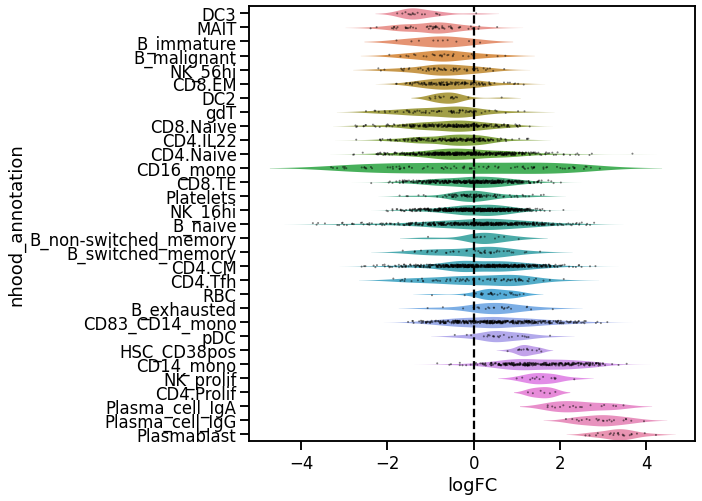

In [291]:
milopy.plot.plot_DA_beeswarm(adata);
plt.show();
milopy.plot.plot_DA_beeswarm(adata_c)

## Compare with _de novo_ integration including disease cases

In [ ]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
adata_p = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design._PAC.h5ad')

## Add dataset specific obs
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_p.obs_names]]
new_obs.index = adata_p.obs_names
adata_p.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_p.obs.columns)], adata_p.obs], 1)


In [ ]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
adata_pc = sc.read_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design._PC.h5ad')


## Add dataset specific obs
new_obs = stephenson_obs.loc[[x.split('10_1038_s41591_021_01329_2-')[-1] for x in adata_pc.obs_names]]
new_obs.index = adata_pc.obs_names
adata_pc.obs = pd.concat([new_obs.loc[:,~new_obs.columns.isin(adata_pc.obs.columns)], adata_pc.obs], 1)


In [314]:
run_milo(adata_p, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')
run_milo(adata_pc, 'P', 'C', sample_col='sample_id', annotation_col='cell_type', design='~Site+is_query')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/an

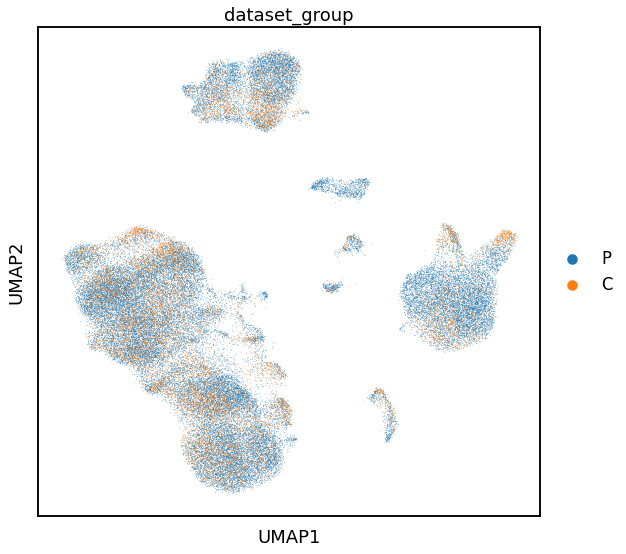

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


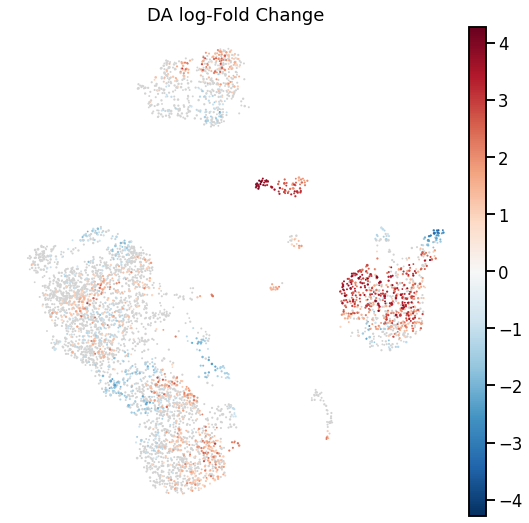

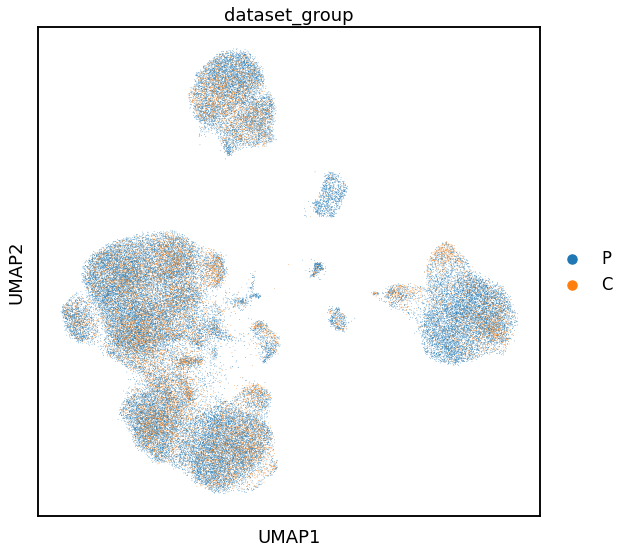

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


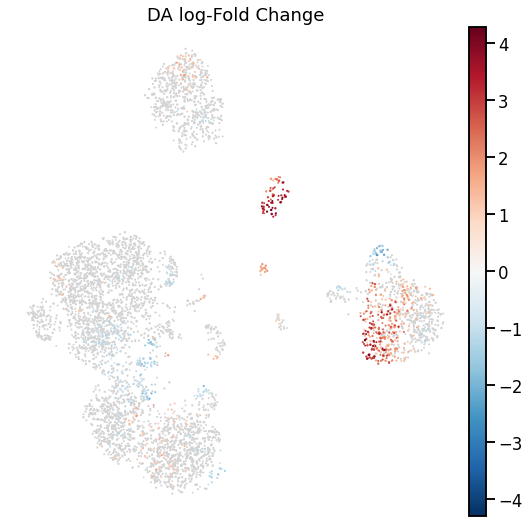

In [315]:
milopy.utils.build_nhood_graph(adata_p)
milopy.utils.build_nhood_graph(adata_pc)
with rc_context({'figure.figsize':[9,9]}):
    sc.pl.umap(adata_p, color='dataset_group')
    milopy.plot.plot_nhood_graph(adata_p, min_size=0.1)
    sc.pl.umap(adata_pc, color='dataset_group')
    milopy.plot.plot_nhood_graph(adata_pc, min_size=0.1)

In [316]:
milopy.utils.annotate_nhoods(adata_p, 'author_cell_type')
adata_p.obs['IFN_signature'] = adata.obs.loc[adata_p.obs_names, 'IFN_signature']
milopy.utils.annotate_nhoods_continuous(adata_p, "IFN_signature")

milopy.utils.annotate_nhoods(adata_pc, 'author_cell_type')
adata_pc.obs['IFN_signature'] = adata.obs.loc[adata_pc.obs_names, 'IFN_signature']
milopy.utils.annotate_nhoods_continuous(adata_pc, "IFN_signature")

In [321]:
pal = sns.color_palette("Paired")
pal[0]

(0.6509803921568628, 0.807843137254902, 0.8901960784313725)

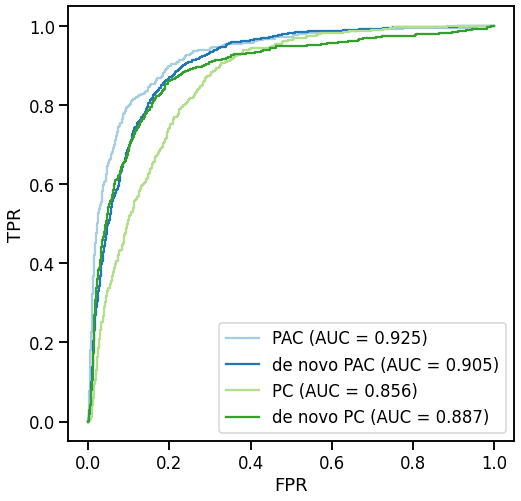

In [323]:
from sklearn.metrics import roc_curve,auc
nhood_adata_p = adata_p.uns['nhood_adata'].copy()
nhood_adata_pc = adata_pc.uns['nhood_adata'].copy()

min_sign = 0.1
nhood_adata.obs['is_IFN_activated'] = nhood_adata.obs['nhood_IFN_signature'] > min_sign
nhood_adata_c.obs['is_IFN_activated'] = nhood_adata_c.obs['nhood_IFN_signature'] > min_sign
nhood_adata_p.obs['is_IFN_activated'] = nhood_adata_p.obs['nhood_IFN_signature'] > min_sign
nhood_adata_pc.obs['is_IFN_activated'] = nhood_adata_pc.obs['nhood_IFN_signature'] > min_sign
fpr, tpr, _ = roc_curve(nhood_adata.obs['is_IFN_activated'], nhood_adata.obs['logFC'])
AUC = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'PAC (AUC = {np.round(AUC, 3)})', color=pal[0]);
fpr, tpr, _ = roc_curve(nhood_adata_p.obs['is_IFN_activated'], nhood_adata_p.obs['logFC'])
AUC = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'de novo PAC (AUC = {np.round(AUC, 3)})', color=pal[1]);
fpr, tpr, _ = roc_curve(nhood_adata_c.obs['is_IFN_activated'], nhood_adata_c.obs['logFC'])
AUC = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'PC (AUC = {np.round(AUC, 3)})', color=pal[2]);
fpr, tpr, _ = roc_curve(nhood_adata_pc.obs['is_IFN_activated'], nhood_adata_pc.obs['logFC'])
AUC = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'de novo PC (AUC = {np.round(AUC, 3)})', color=pal[3]);
plt.legend();
plt.xlabel("FPR");
plt.ylabel("TPR");


In [324]:
df1 = nhood_adata_p.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df1['design'] = 'PAC'
df2 = nhood_adata_pc.obs[['nhood_IFN_signature', 'logFC', "SpatialFDR", 'nhood_annotation']]
df2['design'] = 'PC'
pl_df = pd.concat([df1,df2])
# pl_cell_types_c = nhood_adata_c.obs.loc[nhood_adata_c.obs['nhood_IFN_signature'] > 0.1, 'nhood_annotation'].astype('str').unique()


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [325]:
%%R -i pl_df
head(pl_df)

  nhood_IFN_signature      logFC SpatialFDR nhood_annotation design
1         -0.04884111  0.4399212 0.56472722          CD4.Tfh    PAC
2         -0.14655889  0.5881863 0.31498710           CD4.CM    PAC
3         -0.06466249  0.0306197 0.97009168   CD83_CD14_mono    PAC
4          0.11947952  1.3394725 0.01226933   CD83_CD14_mono    PAC
5         -0.15582995 -0.5220446 0.33904163           CD4.CM    PAC
6         -0.06020073  1.2050497 0.03165099           CD4.CM    PAC


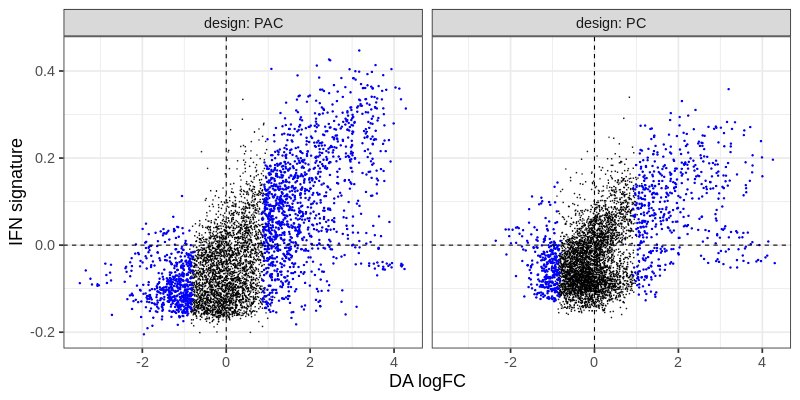

In [326]:
%%R -w 800 -h 400
pl_df %>%
    group_by(nhood_annotation, design) %>%
    mutate(frac_activated = sum(nhood_IFN_signature > 0.1)/n())  %>%
    ggplot(aes(x=logFC, y=nhood_IFN_signature)) +
    geom_point(size=0.2, alpha=0.7) +
    geom_point(data = . %>% filter(SpatialFDR < 0.1), color='blue', size=0.5, alpha=0.9) +
    theme_bw(base_size=18) +
    facet_grid(~design, labeller=label_both) +
    scale_color_brewer(palette='Accent') +
    theme(legend.position='top') +
    geom_vline(xintercept=0, linetype='dashed', color='black') +
    geom_hline(yintercept=0, linetype='dashed', color='black') +
    xlab("DA logFC") + ylab("IFN signature")

### Analysis on severity

In [344]:
df = adata.obs[['donor_id','Status_on_day_collection_summary', "Site"]].drop_duplicates()
df.Status_on_day_collection_summary.value_counts()

Moderate        30
Healthy         23
Mild            23
Critical        15
Severe          13
Asymptomatic     9
LPS_10hours      3
LPS_90mins       3
Name: Status_on_day_collection_summary, dtype: int64

In [339]:
adata.obs.columns

Index(['n_genes', 'total_counts_mt', 'pct_counts_mt', 'initial_clustering',
       'Resample', 'Collection_Day', 'Swab_result', 'Status', 'Smoker',
       'Status_on_day_collection', 'Status_on_day_collection_summary',
       'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status',
       'Outcome', 'patient_id', 'cell_type_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'ethnicity_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'author_cell_type', 'organism', 'sex',
       'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id',
       'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top

In [ ]:
milopy.core.DA_nhoods(adata, design)